In [5]:
import time
import numpy as np
import qiskit
import dimod
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import *
from qiskit_optimization.problems import QuadraticProgram
from qiskit_optimization.algorithms import MinimumEigenOptimizer
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import QAOA
from qiskit_aer import Aer
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.optimizers import SPSA
from qiskit.primitives import BackendSampler
from qiskit.primitives import Sampler
from qiskit_optimization import QuadraticProgram

In [31]:
Diccionario={(1, 1): -9.626557575259653e-05, (2, 2): -1.726328109796782e-05, (3, 3): -0.00010051278615308412, (4, 4): -0.0002036557915305881, (1, 2): 1.2323167015803069e-05, (1, 3): 5.824880612740829e-06, (1, 4): 3.928456524946224e-05, (2, 1): 1.2323167015803069e-05, (2, 3): 5.223848725612105e-05, (2, 4): 2.58749949503751e-05, (3, 1): 5.824880612740829e-06, (3, 2): 5.223848725612105e-05, (3, 4): 2.6338325684943215e-05, (4, 1): 3.928456524946224e-05, (4, 2): 2.58749949503751e-05, (4, 3): 2.6338325684943215e-05, (5, 5): -3.0972446e-06, (1, 5): 5.070411657204232e-07, (5, 1): 5.070411657204232e-07, (2, 5): 1.100178664836804e-06, (5, 2): 1.100178664836804e-06, (3, 5): 5.139288721534019e-07, (5, 3): 5.139288721534019e-07, (4, 5): 7.346003770836163e-07, (5, 4): 7.346003770836163e-07}
#Diccionario={(2, 2): 1/4, (3, 3): -3/4, (1,2): -1, (2,3):3/4}
#Diccionario={(1, 1): 2, (1, 2): -4, (2,3): 3}
#Diccionario={(1, 1): 1, (2, 2): -2, (3,3): 3, (1, 2): 1, (1, 3): -1, (2,3): 2}


In [12]:
from qiskit.quantum_info import SparsePauliOp

# Diccionario original
diccionario = {
    (1, 1): -9.626557575259653e-05, (2, 2): -1.726328109796782e-05, 
    (3, 3): -0.00010051278615308412, (4, 4): -0.0002036557915305881, 
    (1, 2): 1.2323167015803069e-05, (1, 3): 5.824880612740829e-06, 
    (1, 4): 3.928456524946224e-05, (2, 1): 1.2323167015803069e-05, 
    (2, 3): 5.223848725612105e-05, (2, 4): 2.58749949503751e-05, 
    (3, 1): 5.824880612740829e-06, (3, 2): 5.223848725612105e-05, 
    (3, 4): 2.6338325684943215e-05, (4, 1): 3.928456524946224e-05, 
    (4, 2): 2.58749949503751e-05, (4, 3): 2.6338325684943215e-05, 
    (5, 5): -3.0972446e-06, (1, 5): 5.070411657204232e-07, 
    (5, 1): 5.070411657204232e-07, (2, 5): 1.100178664836804e-06, 
    (5, 2): 1.100178664836804e-06, (3, 5): 5.139288721534019e-07, 
    (5, 3): 5.139288721534019e-07, (4, 5): 7.346003770836163e-07, 
    (5, 4): 7.346003770836163e-07
}

# Lista para almacenar los términos Pauli
pauli_list = []

# Función para generar la cadena de Pauli a partir de los índices
def generate_pauli_string(i, j, n_qubits):
    pauli_string = ["I"] * n_qubits
    pauli_string[i - 1] = "Z"
    if i != j:
        pauli_string[j - 1] = "Z"
    return "".join(pauli_string)

# Número de qubits
n_qubits = 5

# Convertir el diccionario al formato de Pauli
for (i, j), value in diccionario.items():
    pauli_string = generate_pauli_string(i, j, n_qubits)
    pauli_list.append((pauli_string, value))

# Crear el SparsePauliOp
op = SparsePauliOp.from_list(pauli_list)

# Mostrar el resultado
print(op)

SparsePauliOp(['ZIIII', 'IZIII', 'IIZII', 'IIIZI', 'ZZIII', 'ZIZII', 'ZIIZI', 'ZZIII', 'IZZII', 'IZIZI', 'ZIZII', 'IZZII', 'IIZZI', 'ZIIZI', 'IZIZI', 'IIZZI', 'IIIIZ', 'ZIIIZ', 'ZIIIZ', 'IZIIZ', 'IZIIZ', 'IIZIZ', 'IIZIZ', 'IIIZZ', 'IIIZZ'],
              coeffs=[-9.62655758e-05+0.j, -1.72632811e-05+0.j, -1.00512786e-04+0.j,
 -2.03655792e-04+0.j,  1.23231670e-05+0.j,  5.82488061e-06+0.j,
  3.92845652e-05+0.j,  1.23231670e-05+0.j,  5.22384873e-05+0.j,
  2.58749950e-05+0.j,  5.82488061e-06+0.j,  5.22384873e-05+0.j,
  2.63383257e-05+0.j,  3.92845652e-05+0.j,  2.58749950e-05+0.j,
  2.63383257e-05+0.j, -3.09724460e-06+0.j,  5.07041166e-07+0.j,
  5.07041166e-07+0.j,  1.10017866e-06+0.j,  1.10017866e-06+0.j,
  5.13928872e-07+0.j,  5.13928872e-07+0.j,  7.34600377e-07+0.j,
  7.34600377e-07+0.j])


In [7]:
def QAOA_Solution2(Diccionario):

    #Transforma el resultado en uno con variables primadas
    Indice_Maximo = max(max(key) for key in Diccionario)
    Diccionario_Primado={}
    for i in range(0,Indice_Maximo+1):
        for j in range(0,Indice_Maximo+1):
            if (i,j) in Diccionario:
                Diccionario_Primado[(f'{i}',f'{j}')]=Diccionario[(i,j)]
    print(Diccionario_Primado)
    

    #Genera el problema
    qp = QuadraticProgram()
    for i in range(1,Indice_Maximo+1):
        if (i,i) in Diccionario:
            qp.binary_var(f'{i}')

    qp.minimize(quadratic = Diccionario_Primado)
    print(qp.export_as_lp_string())


    sim = Aer.get_backend('aer_simulator_statevector')
    sampler = BackendSampler(sim)
    spsa = SPSA(maxiter=250)
    qaoa = QAOA(sampler=sampler, optimizer=spsa, reps=3)
    qaoa_optimizer = MinimumEigenOptimizer(qaoa)
    result2 = qaoa_optimizer.solve(qp)
    res2 = np.array(result2.x)
    print('QAOA')
    print(result2)


    return res2

In [28]:
QAOA_Solution2(Diccionario)

{('1', '1'): -9.626557575259653e-05, ('1', '2'): 1.2323167015803069e-05, ('1', '3'): 5.824880612740829e-06, ('1', '4'): 3.928456524946224e-05, ('1', '5'): 5.070411657204232e-07, ('2', '1'): 1.2323167015803069e-05, ('2', '2'): -1.726328109796782e-05, ('2', '3'): 5.223848725612105e-05, ('2', '4'): 2.58749949503751e-05, ('2', '5'): 1.100178664836804e-06, ('3', '1'): 5.824880612740829e-06, ('3', '2'): 5.223848725612105e-05, ('3', '3'): -0.00010051278615308412, ('3', '4'): 2.6338325684943215e-05, ('3', '5'): 5.139288721534019e-07, ('4', '1'): 3.928456524946224e-05, ('4', '2'): 2.58749949503751e-05, ('4', '3'): 2.6338325684943215e-05, ('4', '4'): -0.0002036557915305881, ('4', '5'): 7.346003770836163e-07, ('5', '1'): 5.070411657204232e-07, ('5', '2'): 1.100178664836804e-06, ('5', '3'): 5.139288721534019e-07, ('5', '4'): 7.346003770836163e-07, ('5', '5'): -3.0972446e-06}
\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: CPLEX

Minimize
 obj: [ - 0.000192531152 x1^2

array([1., 0., 1., 1., 0.])

In [3]:
def Quantum_annealing_simulator(Diccionario):
    J=Diccionario
    h={}
    problem = dimod.BinaryQuadraticModel(h, J, 0.0, dimod.BINARY)
    print(problem)

    
    solver2 = dimod.ExactSolver()
    response = solver2.sample(problem)


    print(response)
    
    return response

In [32]:
Quantum_annealing_simulator(Diccionario)

BinaryQuadraticModel({1: -9.626557575259653e-05, 2: -1.726328109796782e-05, 3: -0.00010051278615308412, 4: -0.0002036557915305881, 5: -3.0972446e-06}, {(2, 1): 2.4646334031606138e-05, (3, 1): 1.1649761225481658e-05, (3, 2): 0.0001044769745122421, (4, 1): 7.856913049892448e-05, (4, 2): 5.17499899007502e-05, (4, 3): 5.267665136988643e-05, (5, 1): 1.0140823314408465e-06, (5, 2): 2.200357329673608e-06, (5, 3): 1.0278577443068038e-06, (5, 4): 1.4692007541672325e-06}, 0.0, 'BINARY')
    1  2  3  4  5    energy num_oc.
9   1  0  1  1  0 -0.000258       1
22  1  0  1  1  1 -0.000257       1
23  0  0  1  1  1 -0.000252       1
8   0  0  1  1  0 -0.000251       1
17  1  0  0  1  1 -0.000222       1
14  1  0  0  1  0 -0.000221       1
16  0  0  0  1  1 -0.000205       1
15  0  0  0  1  0 -0.000204       1
25  1  0  1  0  1 -0.000186       1
6   1  0  1  0  0 -0.000185       1
12  0  1  0  1  0 -0.000169       1
19  0  1  0  1  1 -0.000169       1
13  1  1  0  1  0 -0.000162       1
18  1  1  0  1

SampleSet(rec.array([([0, 0, 0, 0, 0],  0.00000000e+00, 1),
           ([1, 0, 0, 0, 0], -9.62655758e-05, 1),
           ([1, 1, 0, 0, 0], -8.88825228e-05, 1),
           ([0, 1, 0, 0, 0], -1.72632811e-05, 1),
           ([0, 1, 1, 0, 0], -1.32990927e-05, 1),
           ([1, 1, 1, 0, 0], -7.32685732e-05, 1),
           ([1, 0, 1, 0, 0], -1.85128601e-04, 1),
           ([0, 0, 1, 0, 0], -1.00512786e-04, 1),
           ([0, 0, 1, 1, 0], -2.51491926e-04, 1),
           ([1, 0, 1, 1, 0], -2.57538610e-04, 1),
           ([1, 1, 1, 1, 0], -9.39285930e-05, 1),
           ([0, 1, 1, 1, 0], -1.12528243e-04, 1),
           ([0, 1, 0, 1, 0], -1.69169083e-04, 1),
           ([1, 1, 0, 1, 0], -1.62219194e-04, 1),
           ([1, 0, 0, 1, 0], -2.21352237e-04, 1),
           ([0, 0, 0, 1, 0], -2.03655792e-04, 1),
           ([0, 0, 0, 1, 1], -2.05283835e-04, 1),
           ([1, 0, 0, 1, 1], -2.21966198e-04, 1),
           ([1, 1, 0, 1, 1], -1.60632798e-04, 1),
           ([0, 1, 0, 1, 1], -1.68596769

0
statevector
Statevector([1.+0.j, 0.+0.j, 0.+0.j, ..., 0.+0.j, 0.+0.j, 0.+0.j],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
mps
1
statevector
Statevector([0.00031716-0.00130002j, 0.        +0.j        ,
             0.        +0.j        , ..., 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
mps
2
statevector
Statevector([0.14185439+0.01486049j, 0.        +0.j        ,
             0.        +0.j        , ..., 0.        +0.j        ,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
mps
3
statevector
Statevector([0.12407689+0.09183149j, 0.08969207-0.12118625j,
             0.        +0.j        , ..., 0.06033201+0.06040733j,
             0.        +0.j        , 0.        +0.j        ],
            dims=(2, 2, 2, 2, 2, 2, 2, 2, 2, 2))
mps
4
statevector
Statevector([-9.47985163e-02-7.42839811e-02j,
             -6.20475479e-02-4.8620369

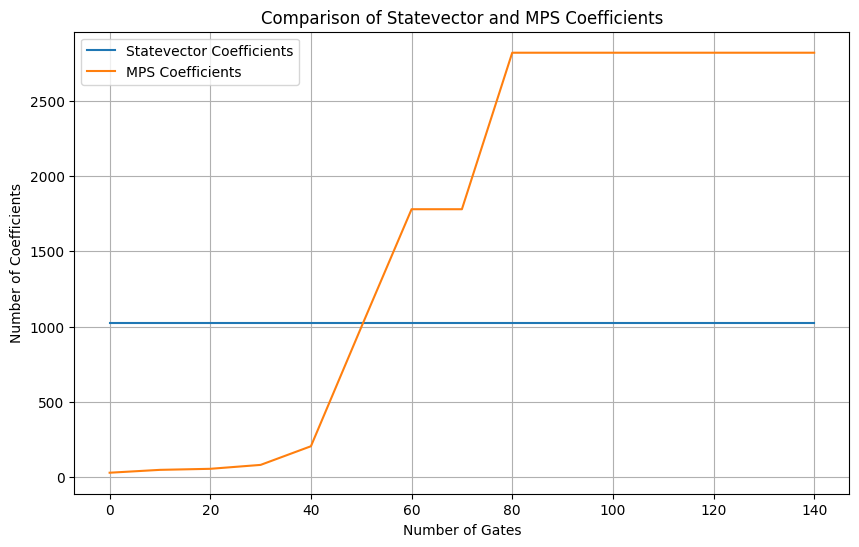

In [2]:
import numpy as np
import warnings
import matplotlib.pyplot as plt
# Suprime todas las advertencias
warnings.filterwarnings("ignore")
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit.quantum_info import Statevector, random_statevector
simulator = AerSimulator(method='matrix_product_state')
def contar_coeficientes(estructura):
    if isinstance(estructura, np.ndarray):
        # Si es un array de NumPy, contar los elementos
        return estructura.size
    elif isinstance(estructura, (list, tuple)):
        # Si es una lista o tupla, recorrer sus elementos y sumar sus conteos
        return sum(contar_coeficientes(subestructura) for subestructura in estructura)
    else:
        # Si es un número o un tipo no iterable, cuenta como 1
        return 1

def add_random_rotation_gate(circuit, qubits):
    gate = np.random.choice(['rx', 'ry', 'rz'])
    qubit = np.random.randint(qubits)
    angle = np.random.uniform(0, 2 * np.pi)
    
    if gate == 'rx':
        circuit.rx(angle, qubit)
    elif gate == 'ry':
        circuit.ry(angle, qubit)
    elif gate == 'rz':
        circuit.rz(angle, qubit)

def add_random_cnot_gate(circuit, qubits):
    ctrl, target = np.random.choice(qubits, 2, replace=False)
    circuit.cx(ctrl, target)

# Crear un circuito cuántico con 30 qubits

num_gates_list = []
num_coefficients_sv_list = []
num_coefficients_mps_list = []

for i in range(10, 11):  # Solo un valor de `i` porque `range(3, 3)` no genera ningún número
    for j in range(0, 15):
        print(j)
        n_qubits = i
        n_gates = j
        circ = QuantumCircuit(n_qubits, n_qubits)

        # Aplicación de las puertas
        for _ in range(n_gates):
            add_random_rotation_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_cnot_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_rotation_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_cnot_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_rotation_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_cnot_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_rotation_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_cnot_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_rotation_gate(circ, n_qubits)

        for _ in range(n_gates):
            add_random_cnot_gate(circ, n_qubits)

        # Define snapshots para el statevector y el MPS
        circ.save_statevector(label='my_sv')
        circ.save_matrix_product_state(label='my_mps')

        # Transpilar y ejecutar el circuito
        tcirc = transpile(circ, simulator)
        result = simulator.run(tcirc).result()
        data = result.data(0)

        statevector = data['my_sv']
        print('statevector')
        print(statevector)

        # Obtener el número de coeficientes del statevector
        num_coefficients_sv = len(statevector)
        num_coefficients_sv_list.append(num_coefficients_sv)

        # Obtener el número de coeficientes del MPS
        mps = data['my_mps']
        print('mps')
    

        def contar_coeficientes(estructura):
            if isinstance(estructura, np.ndarray):
                return estructura.size
            elif isinstance(estructura, (list, tuple)):
                return sum(contar_coeficientes(subestructura) for subestructura in estructura)
            else:
                return 1

        num_coeficientes_mps = contar_coeficientes(mps)
        num_coefficients_mps_list.append(num_coeficientes_mps)

        num_gates_list.append(n_gates*10)

# Graficar los resultados
plt.figure(figsize=(10, 6))
plt.plot(num_gates_list, num_coefficients_sv_list, label='Statevector Coefficients')
plt.plot(num_gates_list, num_coefficients_mps_list, label='MPS Coefficients')
plt.xlabel('Number of Gates')
plt.ylabel('Number of Coefficients')
plt.title('Comparison of Statevector and MPS Coefficients')
plt.legend()
plt.grid(True)
plt.show()
